In [1]:
# add command for jupyter to reload modules automatically
%load_ext autoreload
%autoreload 2

In [34]:
import json
from pathlib import Path
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt

import os

import torch

from config import load_config
from data import CLEVRSplit, CLEVRMultimodalSplit, CLEVRTextSplit, Scene, CollatorForMaskedLanguageModeling
from model import MultimodalModel, MultimodalPretrainingModel
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torch.nn.functional import softmax


pp = pprint.PrettyPrinter(indent=2)

In [3]:
from torch.utils.data import default_collate

class CollatorForMaskedSelectedTokens:
    def __init__(self, config, processor, tokens):
        self.config = config
        self.token_to_mask_idxs = torch.tensor(tokens)
        self.special_token_idxs = torch.tensor(processor.special_token_idxs)
        self.mask_token_idx = processor.mask_token_idx
        self.image_patch_sizes = config.patch_height, config.patch_width

    def __call__(self, batch):
        images, scenes = default_collate(batch)
        scenes, scenes_labels = self.build_targets(scenes)
        images_labels = self.build_null_image_targets(images)
        labels = torch.cat((images_labels, scenes_labels), dim=1)
        return images, scenes, labels

    def build_null_image_targets(self, images):
        b, c, h, w = images.shape
        n_patches = config.n_patches
        return torch.full((b, n_patches), -100)

    def build_targets(self, inputs):
        labels = inputs.clone()
        masked_indices = torch.isin(labels, self.token_to_mask_idxs)
        labels[~masked_indices] = -100
        inputs[masked_indices] = self.mask_token_idx
        
        return inputs, labels

    
class CollatorForMaskedRandomSelectedTokens:
    def __init__(self, config, processor, tokens, p):
        self.config = config
        self.token_to_mask_idxs = torch.tensor(tokens)
        self.special_token_idxs = torch.tensor(processor.special_token_idxs)
        self.mask_token_idx = processor.mask_token_idx
        self.image_patch_sizes = config.patch_height, config.patch_width
        self.p = p

    def __call__(self, batch):
        images, scenes = default_collate(batch)
        scenes, scenes_labels = self.build_targets(scenes)
        images_labels = self.build_null_image_targets(images)
        labels = torch.cat((images_labels, scenes_labels), dim=1)
        return images, scenes, labels

    def build_null_image_targets(self, images):
        b, c, h, w = images.shape
        n_patches = config.n_patches
        return torch.full((b, n_patches), -100)

    def build_targets(self, inputs):
        labels = inputs.clone()
        masked_indices = torch.isin(labels, self.token_to_mask_idxs)
        is_selected = torch.bernoulli(torch.full_like(labels, self.p, dtype=torch.float)).bool()
        masked_indices = masked_indices & is_selected 
        labels[~masked_indices] = -100
        inputs[masked_indices] = self.mask_token_idx
        
        return inputs, labels
    

class IdentityCollator:
    def __init__(self, config, processor):
        self.config = config
        self.special_token_idxs = torch.tensor(processor.special_token_idxs)
        self.image_patch_sizes = config.patch_height, config.patch_width

    def __call__(self, batch):
        images, scenes = default_collate(batch)
        scenes, scenes_labels = self.build_targets(scenes)
        images_labels = self.build_null_image_targets(images)
        labels = torch.cat((images_labels, scenes_labels), dim=1)
        return images, scenes, labels

    def build_null_image_targets(self, images):
        b, c, h, w = images.shape
        n_patches = config.n_patches
        return torch.full((b, n_patches), -100)

    def build_targets(self, inputs):
        labels = inputs.clone()
        special_token_indices = torch.isin(labels, self.special_token_idxs)
        labels[special_token_indices] = -100
        
        return inputs, labels

In [4]:
# from config import load_config
    
# config = load_config()
# config.shuffle_object_identities = True
# config.display_object_properties = False

In [5]:
# config_to_copy = {
#     'base_path': '/workspace1/fidelrio/CLEVR_CoGenT_v1.0',
#     'batch_size': 64,
#     'd_hidden': 256,
#     'display_object_properties': False,
#     'filter_symmetric_relations': True,
#     'lr': 0.01,
#     'max_epochs': 200,
#     'max_question_size': 45,
#     'max_scene_size': 659,
#     'n_head': 4,
#     'n_layers': 4,
#     'n_outputs': 28,
#     'n_patches': 100,
#     'n_tokens': 117,
#     'only_front_right_relations': True,
#     'pad_idx': 1,
#     'patch_height': 32,
#     'patch_width': 48,
#     'rels_to_sample': 50,
#     'resume_training': False,
#     'use_txt_scene': True,
#  }

# for k, v in vars(config).items():
#     if k in config_to_copy and config_to_copy[k] != v:
#         print(k, v, config_to_copy[k])

In [6]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

In [12]:
exp_name = 'multimodal-pretraining-v2--mlm_probability=0.15--rels_to_sample=5'
# exp_name = 'multimodal-pretraining--mlm_probability=0.15--rels_to_sample=5--vit-frozen--long'
# exp_name = 'multimodal-pretraining--mlm_probability=0.15--rels_to_sample=5--vit-frozen--aug_zero_indep=100'
# exp_name = 'image-pretraining--mp_probability=0.75--rels_to_sample=5'

resume_from_path = f'outputs/{exp_name}/last.ckpt'
# resume_from_path = f'outputs/{exp_name}/last-v1.ckpt'
# resume_from_path = f'outputs/{exp_name}/epoch=500-step=68637.ckpt'

checkpoint = torch.load(resume_from_path)

print('Epoch:', checkpoint['epoch'])

Epoch: 632


In [35]:
# checkpoint

In [14]:
!ls outputs/$exp_name
!ls outputs/

'epoch=109-step=15070.ckpt'  'epoch=39-step=5480.ckpt'
'epoch=119-step=16440.ckpt'  'epoch=409-step=56170.ckpt'
'epoch=129-step=17810.ckpt'  'epoch=419-step=57540.ckpt'
'epoch=139-step=19180.ckpt'  'epoch=429-step=58910.ckpt'
'epoch=149-step=20550.ckpt'  'epoch=439-step=60280.ckpt'
'epoch=159-step=21920.ckpt'  'epoch=449-step=61650.ckpt'
'epoch=169-step=23290.ckpt'  'epoch=459-step=63020.ckpt'
'epoch=179-step=24660.ckpt'  'epoch=469-step=64390.ckpt'
'epoch=189-step=26030.ckpt'  'epoch=479-step=65760.ckpt'
'epoch=199-step=27400.ckpt'  'epoch=489-step=67130.ckpt'
'epoch=19-step=2740.ckpt'    'epoch=499-step=68500.ckpt'
'epoch=209-step=28770.ckpt'  'epoch=49-step=6850.ckpt'
'epoch=219-step=30140.ckpt'  'epoch=509-step=69870.ckpt'
'epoch=229-step=31510.ckpt'  'epoch=519-step=71240.ckpt'
'epoch=239-step=32880.ckpt'  'epoch=529-step=72610.ckpt'
'epoch=249-step=34250.ckpt'  'epoch=539-step=73980.ckpt'
'epoch=259-step=35620.ckpt'  'epoch=549-step=75350.ckpt'
'epoch=269-step=36990.ckpt'  'epoch

In [15]:
config = load_config(exp_name)

Loading multimodal-pretraining-v2--mlm_probability=0.15--rels_to_sample=5 last checkpoint config from outputs/multimodal-pretraining-v2--mlm_probability=0.15--rels_to_sample=5/last.ckpt
Updating arg: patch_height = 16
Updating arg: patch_width = 16


In [16]:
pp.pprint(vars(config))

{ 'aug_zero': 0,
  'aug_zero_independent': False,
  'base_path': '/workspace1/fidelrio/CLEVR_CoGenT_v1.0',
  'batch_size': 256,
  'comet_experiment_key': 'bc8e085f15644ea4bedaab9bd1dd19d5',
  'd_hidden': 256,
  'display_object_properties': False,
  'filter_symmetric_relations': True,
  'freeze_vit_embedding': False,
  'image_pretraining': False,
  'lr': 0.0001,
  'max_epochs': 1000,
  'max_question_size': 45,
  'max_scene_size': 80,
  'mlm_probability': 0.15,
  'mp_probability': 0.75,
  'multimodal_pretraining': True,
  'multimodal_training': False,
  'n_head': 4,
  'n_layers': 4,
  'n_outputs': 28,
  'n_patches': 196,
  'n_tokens': 96,
  'not_normalize_image': False,
  'only_front_right_relations': False,
  'optimizer': 'adam',
  'pad_idx': 1,
  'patch_height': 16,
  'patch_width': 16,
  'profile': False,
  'rels_to_sample': 5,
  'resume_training': False,
  'seed': 42,
  'shuffle_object_identities': True,
  'start_from': '',
  'use_txt_scene': False,
  'use_vit_embedding': False,
  'v

In [17]:
config.vocabulary_path =  '/workspace1/fidelrio/CLEVR_CoGenT_v1.0/vocab.txt'
config.base_path = '/workspace1/fidelrio/CLEVR_CoGenT_v1.0'

In [18]:
train_dataset, test_dataset, systematic_dataset = CLEVRMultimodalSplit.build_splits(
    config
)

In [19]:
model = MultimodalModel(config)
training_model = MultimodalPretrainingModel(model, config)
training_model.load_state_dict(checkpoint['state_dict'])

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


<All keys matched successfully>

In [20]:
processor = test_dataset.processor

In [21]:
relation_tokens = sorted([processor.vocabulary[w] for w in ['left', 'right', 'behind', 'front']])
color_tokens = sorted([processor.vocabulary[w] for w in 
                       ['blue', 'brown', 'cyan', 'green', 'red', 'purple', 'yellow', 'gray']])
shapes_tokens = sorted([processor.vocabulary[w] for w in ['cylinder', 'sphere', 'cube']])
materials_tokens = sorted([processor.vocabulary[w] for w in ['metal', 'rubber']])
size_tokens = sorted([processor.vocabulary[w] for w in ['small', 'large']])

In [22]:
relation_tokens

[26, 45, 57, 75]

In [23]:
collator = CollatorForMaskedLanguageModeling(config, processor)
# collator = CollatorForMaskedSelectedTokens(config, processor, tokens=materials_tokens)
# collator = CollatorForMaskedRandomSelectedTokens(config, processor, tokens=relation_tokens, p=0.2)
# collator = IdentityCollator(config, processor)

In [24]:
sample_idx = 333
# sample_idx = random.randint(0, len(test_dataset))
image, scene = test_dataset.retrieve_raw(sample_idx)
image_tensor, scene_tensor = test_dataset[sample_idx]

collated_images, collated_scenes, collated_labels = collator([(image_tensor, scene_tensor)])


# image_tensor0, scene_tensor0 = test_dataset[sample_idx]
# image_tensor1, scene_tensor1 = test_dataset[sample_idx+1]

# collated_images, collated_scenes, collated_labels = collator([
#     (image_tensor0, scene_tensor0), (image_tensor1, scene_tensor1)])

print(sample_idx)

333


[CLS] [O0] small gray metal sphere 
      [O5] large blue rubber cube 
      [O2] large yellow metal cube 
      [O3] small cyan metal cylinder 
      [O6] small green rubber sphere 
      [O1] small brown rubber cube 
      [O4] small purple metal cylinder 
      [O4] right [O5] 
      [O0] behind [O1] 
      [O3] behind [O5] 
      [O1] right [O0] 
      [O1] behind [O6]                  

[CLS] [MASK] [MASK] gray metal sphere 
      [O5] large blue rubber cube 
      [MASK] large yellow metal cube 
      [MASK] small cyan [MASK] cylinder 
      [O6] small green [MASK] sphere 
      [O1] small brown [MASK] cube 
      [O4] small purple metal cylinder 
      [O4] right [O5] 
      [O0] behind [O1] 
      [O3] behind [O5] 
      [O1] right [MASK] 
      [MASK] behind [O6]                  


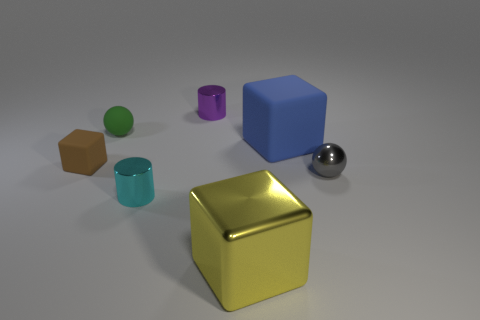

In [25]:
print_scene_tensor(scene_tensor)
print()
print_scene_tensor(collated_scenes[0])

image

In [26]:
output_logits = model(collated_images, collated_scenes)

# output_logits.reshape(1,277,101,98).sum(-2)

confidences = softmax(output_logits, dim=-1).max(dim=-1).values
predictions = output_logits.argmax(dim=-1)

In [27]:
output_logits.shape, collated_labels.shape

(torch.Size([1, 276, 96]), torch.Size([1, 276]))

In [40]:
loss = F.cross_entropy(output_logits.transpose(1,2), collated_labels).item()
acc = training_model.calc_accuracy(output_logits, collated_labels)
mr, mrr = training_model.calc_rank(output_logits, collated_labels)
gt_prob, rel_gt_prob = training_model.calc_prob_metrics(output_logits, collated_labels)
acc_at_5 = training_model.calc_accuracy_at_perc(output_logits, collated_labels, percentage=0.05)
acc_at_10 = training_model.calc_accuracy_at_perc(output_logits, collated_labels, percentage=0.1)

In [43]:
print(f'loss:        {loss:.4f}')
print(f'acc:         {acc:.4f}')
print(f'mr:          {mr:.4f}')
print(f'mrr:         {mrr:.4f}')
print(f'gt_prob:     {gt_prob:.4f}')
print(f'rel_gt_prob: {rel_gt_prob:.4f}')
print(f'acc_at_5:    {acc_at_5:.4f}')
print(f'acc_at_10:   {acc_at_10:.4f}')

loss:        0.6909
acc:         0.5000
mr:          1.9000
mrr:         0.7033
gt_prob:     0.6323
rel_gt_prob: 0.9624
acc_at_5:    0.9000
acc_at_10:   1.0000


In [46]:
import math
math.exp(-loss)

0.501110711762161

In [59]:
masked = collated_labels != -100
masked_labels = collated_labels[masked]

non_reduced_loss = F.cross_entropy(output_logits.transpose(1,2), collated_labels, reduction='none')

In [55]:
masked_labels

tensor([ 4, 82, 76,  6,  7, 63, 76, 76,  4,  5])

In [68]:
softmax(output_logits[masked])[torch.arange(10),masked_labels].mean()

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(0.6323, grad_fn=<MeanBackward0>)

In [70]:
torch.exp(-non_reduced_loss[masked].mean().detach())

tensor(0.5011)

In [ ]:
mask = collated_labels != -100
torch.topk(softmax(output_logits[mask]), k=3).values.squeeze(), collated_labels[mask]

In [ ]:
print_parallel(
    scene_tensor,
    collated_scenes[0],
    predictions[0][-80:],
    confidences[0][-80:],
    titles=['gd_tth', 'input', 'output']
)

In [ ]:
print_parallel(
    scene_tensor,
    collated_scenes[0],
    predictions[0][-80:],
    confidences[0][-80:],
    titles=['gd_tth', 'input', 'output']
)

In [ ]:
output_logits.reshape(1,277,101,98).sum(-2).shape

In [ ]:
torch.arange(9898)[None,:].reshape(1,101,98)

In [ ]:
config.n_tokens * (config.aug_zero + 1), config.aug_zero

In [ ]:
assert False

In [ ]:
trainer = Trainer(max_epochs=config.max_epochs,
                  accelerator="gpu",
                  devices=torch.cuda.device_count(),
#                   strategy='ddp_find_unused_parameters_false',
#                   precision="16",
#                   deterministic=True,
#                   logger=comet_logger,
#                   callbacks=[checkpoint_callback]
)

In [ ]:
relation_tokens = sorted(
    [processor.vocabulary[w] for w in ['left', 'right', 'behind', 'front']])
color_tokens = sorted(
    [processor.vocabulary[w] for w in ['blue', 'brown', 'cyan', 'green', 'red', 'purple', 'yellow', 'gray']])
shapes_tokens = sorted(
    [processor.vocabulary[w] for w in ['cylinder', 'sphere', 'cube']])
materials_tokens = sorted(
    [processor.vocabulary[w] for w in ['metal', 'rubber']])
size_tokens = sorted(
    [processor.vocabulary[w] for w in ['small', 'large']])

random_baseline = {
    'relation':  1 / len(relation_tokens),
    'color':  1 / len(color_tokens),
    'shapes':  1 / len(shapes_tokens),
    'materials':  1 / len(materials_tokens),
    'size':  1 / len(size_tokens),
    'identity':  1 / len(processor.vocabulary),
}

In [ ]:
config.batch_size

In [ ]:
from torch.utils.data import Subset
import random

In [ ]:
test_dataset_original = test_dataset
systematic_dataset_original = systematic_dataset

In [ ]:
test_indices = random.sample(range(len(test_dataset)), k=1500)
test_dataset = Subset(test_dataset, test_indices)
systematic_indices = random.sample(range(len(systematic_dataset)), k=1500)
systematic_dataset = Subset(systematic_dataset, systematic_indices)

In [ ]:
%%time

results = {}

collate_fns = [
    ('relation', CollatorForMaskedSelectedTokens(config, processor, tokens=relation_tokens)),
    ('color', CollatorForMaskedSelectedTokens(config, processor, tokens=color_tokens)),
    ('shapes', CollatorForMaskedSelectedTokens(config, processor, tokens=shapes_tokens)),
    ('materials', CollatorForMaskedSelectedTokens(config, processor, tokens=materials_tokens)),
    ('size', CollatorForMaskedSelectedTokens(config, processor, tokens=size_tokens)),
    ('identity', IdentityCollator(config, processor)),
]
# collate_fns = [
#     ('relation', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=relation_tokens, p=0.2)),
#     ('color', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=color_tokens, p=0.2)),
#     ('shapes', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=shapes_tokens, p=0.2)),
#     ('materials', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=materials_tokens, p=0.2)),
#     ('size', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=size_tokens, p=0.2)),
#     ('identity', IdentityCollator(config, processor)),
# ]
dlkwargs = {
    'batch_size': 512,
    'num_workers': int(os.environ.get("SLURM_JOB_CPUS_PER_TASK", 8)),
    'pin_memory': torch.cuda.is_available(),
}

for name, collate_fn in collate_fns:
#     test_dataset_subset = Subset(test_dataset, range(500))
#     systematic_dataset_subset = Subset(systematic_dataset, range(500))

    # train_loader = DataLoader(train_dataset, shuffle=True, collate_fn, **dlkwargs)
    test_loader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn, **dlkwargs)
    systematic_loader = DataLoader(systematic_dataset, shuffle=False, collate_fn=collate_fn, **dlkwargs)

    results[name] = trainer.test(training_model, dataloaders=[test_loader, systematic_loader])

In [ ]:
categories = results.keys()
values1 = [results[cat][0]['test_acc/dataloader_idx_0'] for cat in categories]
values2 = [results[cat][1]['systematic_test_acc/dataloader_idx_1'] for cat in categories]
valuesR = [random_baseline[cat] for cat in categories]

# Define width of bars
bar_width = 0.25

# Create bars for each category
plt.bar([x - bar_width for x in range(len(categories))], values1, width=bar_width, label='Test')
plt.bar([x for x in range(len(categories))], values2, width=bar_width, label='Systematic')
plt.bar([x + bar_width for x in range(len(categories))], valuesR, width=bar_width, label='Random')

# Add labels and title
plt.xlabel('Measure')
plt.ylabel('Accuracy')
plt.ylim(0., 1.)
# plt.title('Bar Chart with Two Columns Per Category')
plt.xticks(range(len(categories)), categories)
plt.legend()

# Show plot
plt.show()

In [ ]:
assert False

In [ ]:
idx = 30
question = train_dataset.questions[idx]
image_idx = question['image_index']
scene = train_dataset.indexed_scenes[image_idx]

question_str = question['question']
answer_str = question['answer']

In [ ]:
config.rels_to_sample = 0
config.only_front_right_relations = False
config.filter_symmetric_relations = True
config.display_object_properties = False

s = Scene.from_dict(scene,
                    shuffle_relations=True,
                    relations_to_sample=config.rels_to_sample,
                    only_front_right=config.only_front_right_relations,
                    filter_symmetric=config.filter_symmetric_relations,
                    always_display_properties=config.display_object_properties)

In [ ]:
config.rels_to_sample, config.only_front_right_relations, config.filter_symmetric_relations, config.display_object_properties

In [ ]:
len(s.relations), list(enumerate(s.relations))

In [ ]:
s.objects

In [ ]:
str(s)

In [ ]:
relations_to_sample = 20
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = False

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']

    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=relations_to_sample,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
max(n_tokens)

In [ ]:
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = False

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']
    
    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=50,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))
    

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = True

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']

    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=50,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))
    

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
dataset_path = Path('/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0')
scenes_path = dataset_path / 'scenes/CLEVR_trainA_scenes.json'
with scenes_path.open('r') as fp:
    scenes = json.load(fp)
    
questions_path = dataset_path / 'questions/CLEVR_trainA_questions.json'
with questions_path.open('r') as fp:
    questions = json.load(fp)

In [ ]:
questions['questions'][3]

In [ ]:
def n_relations(scene):
    relations = ['behind', 'front']#, 'left', 'right']
    count = 0
    relationships = scene['relationships']
    for r in relations:
        count += sum(map(len, relationships[r]))
    return count

n_relations(scenes['scenes'][0])

In [ ]:
(scenes['scenes'][0])

In [ ]:
n_relations_per_example = list(map(n_relations, scenes['scenes']))
plt.hist(n_relations_per_example)
plt.plot()

In [ ]:
def n_objects(scene):
    return len(scene['objects'])

In [ ]:
n_objects_per_example = list(map(n_objects, scenes['scenes']))
plt.hist(n_objects_per_example, bins=max(n_objects_per_example)-3)
plt.plot()

In [ ]:
def object_to_text(obj, obj_idx):
    properties = ['size', 'color', 'material', 'shape']
    obj_str = [f'[O{obj_idx}]'] + [obj[prop] for prop in properties]
    return ' '.join(obj_str)

def relations_to_text(relations):
#     relation_types = ['behind', 'front', 'left', 'right']
    relation_types = ['front', 'right'] # symetric relations

    relations_str = []
    for relation_type in relation_types:
        relation = relations[relation_type]
        for obj, subjs in enumerate(relation):
            relation_str = [f'[O{obj}] {relation_type} [O{subj}]' for subj in subjs]
            relations_str.extend(relation_str)
    
    return relations_str

def scene_to_txt(scene, rels_to_sample=None, shuffle=True):
    objs_strs = []
    for obj_idx, obj in enumerate(scene['objects']):
        objs_strs.append(object_to_text(obj, obj_idx=obj_idx))
    
    relations_strs = relations_to_text(scene['relationships'])
    if rels_to_sample and rels_to_sample < len(relations_strs):
        relations_strs = random.sample(relations_strs, k)
    if shuffle:
        random.shuffle(relations_strs)

    return ' [SEP] '.join(objs_strs + relations_strs)

In [ ]:
from PIL import Image
ip = '/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0/images/trainA/' + questions['questions'][8888]['image_filename']
Image.open(ip)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][0], obj_idx=0)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][1], obj_idx=1)

In [ ]:
relations_to_text(scenes['scenes'][8888]['relationships'])

In [ ]:
scene_to_txt(scenes['scenes'][8888])

In [ ]:
# scene_to_txt(scenes['scenes'][8888], rels_to_sample=5)

In [ ]:
to_str = lambda s: str(Scene.from_dict(s, 
                                        relations_to_sample=config.rels_to_sample,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(to_str, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
str_fnc = lambda s: str(Scene.from_dict(s, relations_to_sample=50,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(str_fnc, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
vocabulary = set()
for scene in scenes['scenes']:
    scene_text = scene_to_txt(scene)
    vocabulary.update(scene_text.split())

vocabulary = ['[CLS]', '[PAD]'] + list(sorted(vocabulary))

In [ ]:
len(vocabulary), vocabulary